<img src="NewYork.jpg" style="height:100px width:250px vertical-align:middle" />

# New York - Population, Venues, Housing Price Analysis

### Arun Leo Prakash
#### 18-Jun-2020

## Table of Contents
<ul>
    <li><a href="#intro">Introduction</a></li>
    <li><a href="#bizprob">Business Problem</a></li>
    <li><a href="#data">Data</a></li>
    <li><a href="#methodology">Methodology</a></li>
    <li><a href="#results">Results</a></li>
    <li><a href="#discussion">Discussion</a></li>
    <li><a href="#conclusion">Conclusion</a></li>
    <li><a href="#references">References</a></li>
</ul>


<a id='intro'></a>
#### Introduction

New York City (NYC), often called New York (NY), is the most populous city in the United States. With an estimated 2019 population of **8,336,817** distributed over about **302.6** square miles (784 km2), New York is also the most densely populated major city in the United States.

Situated on one of the world's largest natural harbors, New York City is composed of five boroughs, each of which is a county of the State of New York. The five boroughs—Brooklyn, Queens, Manhattan, the Bronx, and Staten Island—were consolidated into a single city in 1898. The city and its metropolitan area constitute the premier gateway for legal immigration to the United States. As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world. New York is home to more than 3.2 million residents born outside the United States, the largest foreign-born population of any city in the world as of 2016. As of 2019, the New York metropolitan area is estimated to produce a gross metropolitan product (GMP) of $2.0 trillion. If the New York metropolitan area were a sovereign state, it would have the eighth-largest economy in the world. New York is home to the highest number of billionaires of any city in the world.

<a id='bizprob'></a>
#### Business Problem

With a population of 8 million, New York is a city with a high population and produces high GDP. Being such a crowded city leads the owners of shops and social sharing places in the city where the population is dense. Business investors expects lower real estate cost, with high density of population and the type of business they want to install is less intense. It is difficult to obtain information that will guide investors in this direction, nowadays.

When we consider all these problems, we can create a map and information chart where the real estate index is placed on New York and each district is clustered according to the venue density. This would help the investor to decide the ideal location to run the business based on the factors mentioned above

<a id='data'></a>
#### Data

Data requirements includes a. spatial data of new york to build maps with boundaries, b. average sales price per sqm for every borough, c. venue data of the neighborhoods. Venue like coffee shops, entertainment related venues depending on the business requirements would be considered as a baseline parameter.

**Data Source**
1. Spatial data for NewYork will be downloaded from https://cocl.us/new_york_dataset/newyork_data.json
2. Population Data per borough from https://en.wikipedia.org/wiki/New_York_City
3. Property sales data to collect average sales price from https://www.kaggle.com/new-york-city/nyc-property-sales


Load the required libraries for analysis

In [3]:
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

import wget
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib.pyplot as plt
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


#### Data Aquistion Cleaning

First step, load the new york Geospatial data into dataframe for map generation.

In [2]:
url = 'https://cocl.us/new_york_dataset/newyork_data.json'
filename = wget.download(url)
print('Data downloaded!')

100% [............................................................................] 115774 / 115774Data downloaded!


In [5]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [6]:
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [7]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In the below section New York Housing Sales Data is loaded, cleansed for using it in our comparison

In [8]:
df_housing = pd.read_csv('nyc-rolling-sales.csv')

In [9]:
##lets remove if there are null values
df_housing=df_housing.dropna() 

# finally check if there is any duplicated value and drop if there are
print(sum(df_housing.duplicated()))
df_housing.drop_duplicates(inplace=True)

0


In [7]:
df_housing.columns

Index(['Unnamed: 0', 'BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE'],
      dtype='object')

There are too many columns we need only YEAR BUILT, BOROUGH, SALE PRICE. First step let us remove the columns and load it into a new data frame.

In [10]:
df_housing_clean = df_housing[['BOROUGH', 'GROSS SQUARE FEET', 'LAND SQUARE FEET', 'SALE PRICE']]

df_housing_clean = df_housing_clean.rename(columns={'GROSS SQUARE FEET': 'gsqf',
                                                    'LAND SQUARE FEET': 'lsqf',
                                                    'SALE PRICE' : 'sale_price',
                                                    'BOROUGH' : 'borough'})

df_housing_clean["sale_price"] = df_housing_clean["sale_price"].str.strip()
df_housing_clean["gsqf"] = df_housing_clean["gsqf"].str.strip()
df_housing_clean["lsqf"] = df_housing_clean["lsqf"].str.strip()

df_housing_clean = df_housing_clean.query("sale_price != '-'  ")
df_housing_clean = df_housing_clean.query("gsqf != '-'  ")
df_housing_clean = df_housing_clean.query("lsqf != '-'  ")

df_housing_clean['sale_price'] = pd.to_numeric(df_housing_clean['sale_price'], errors='coerce') 
df_housing_clean['gsqf'] = pd.to_numeric(df_housing_clean['gsqf'], errors='coerce')
df_housing_clean['lsqf'] = pd.to_numeric(df_housing_clean['lsqf'], errors='coerce')

In [11]:
df_housing_clean = df_housing[['BOROUGH', 'SALE PRICE', 'YEAR BUILT', 'TOTAL UNITS']]

In [12]:
df_housing_clean[df_housing_clean['YEAR BUILT']==0]['YEAR BUILT'].count()

6970

In [13]:
df_housing_clean=df_housing_clean[df_housing_clean['YEAR BUILT']!=0].copy()

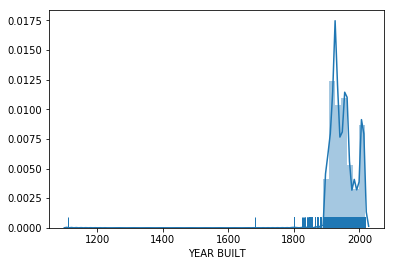

In [14]:
sns.distplot(df_housing_clean['YEAR BUILT'], bins=50, rug=True)
plt.show()

In [16]:
df_housing_clean[df_housing_clean['TOTAL UNITS']==0]['TOTAL UNITS'].count()

0

In [17]:
df_housing_clean=df_housing_clean[df_housing_clean['TOTAL UNITS']!=0].copy()

In [18]:
df_housing_clean = df_housing_clean.rename(columns={'SALE PRICE' : 'sale_price',
                                                    'BOROUGH' : 'borough'})

In [16]:
df_housing_clean.shape

(60714, 4)

In [17]:
df_housing_clean.head()

borough sale_price  YEAR BUILT  TOTAL UNITS
0        1    6625000        1900            5
1        1        -          1900           31
2        1        -          1900           17
3        1    3936272        1913           10
4        1    8000000        1900            6

In [19]:
# Mapping from number reference to borough
#Manhattan (1), Bronx (2), Brooklyn (3), Queens (4), and Staten Island (5)
state_abbrev = {1: 'Manhattan',
                2: 'Bronx',
                3: 'Brooklyn',
                4: 'Queens',
                5: 'Staten Island'}

# Function to apply
def abbreviate_borough(housing):
    if housing['borough'] in state_abbrev.keys():
        abbrev = state_abbrev[housing['borough']]
        return abbrev
    else:
        return housing['borough']
    
df_housing_clean['borough'] = df_housing_clean.apply(abbreviate_borough, axis=1)

In [20]:
df_housing_clean.dtypes

borough        object
sale_price     object
YEAR BUILT      int64
TOTAL UNITS     int64
dtype: object

next step, convert the sale_price to numeric

In [21]:
df_housing_clean["sale_price"] = df_housing_clean["sale_price"].str.strip()

In [22]:
df_housing_clean = df_housing_clean.query("sale_price != '-'  ")

In [23]:
df_housing_clean.shape

(49128, 4)

In [24]:
df_housing_clean['sale_price'] = pd.to_numeric(df_housing_clean['sale_price'], errors='coerce') 

In [25]:
df_housing_clean.dtypes

borough        object
sale_price      int64
YEAR BUILT      int64
TOTAL UNITS     int64
dtype: object

In [26]:
df_housing_clean[(df_housing_clean['sale_price']<10000) | (df_housing_clean['sale_price']>10000000)]['sale_price'].count() /len(df_housing_clean)

0.2159664549747598

21% of the sale prices are either less than 10,000 or greater than $10,000,000. We have to drop all these observations from the data

In [27]:
df_housing_clean= df_housing_clean[(df_housing_clean['sale_price']>10000) & (df_housing_clean['sale_price']<10000000)].copy()
df_housing_clean.describe()

sale_price    YEAR BUILT   TOTAL UNITS
count  3.845700e+04  38457.000000  38457.000000
mean   1.077431e+06   1953.056115      2.191123
std    1.270522e+06     37.838285     17.841976
min    1.000100e+04   1800.000000      1.000000
25%    4.550000e+05   1923.000000      1.000000
50%    6.880000e+05   1941.000000      1.000000
75%    1.110000e+06   1989.000000      2.000000
max    9.999999e+06   2017.000000   2261.000000

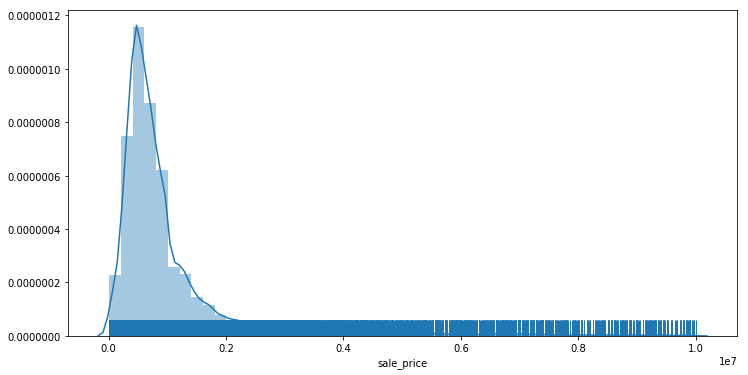

In [28]:
plt.figure(figsize=(12,6))
sns.distplot(df_housing_clean['sale_price'], kde=True, bins=50, rug=True)
plt.show()

In [29]:
df_housing_clean= df_housing_clean[(df_housing_clean['sale_price']<4000000)]

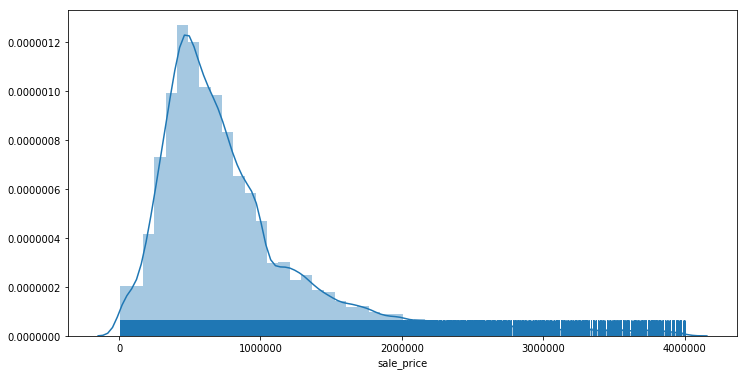

In [30]:
plt.figure(figsize=(12,6))
sns.distplot(df_housing_clean['sale_price'], kde=True, bins=50, rug=True)
plt.show()

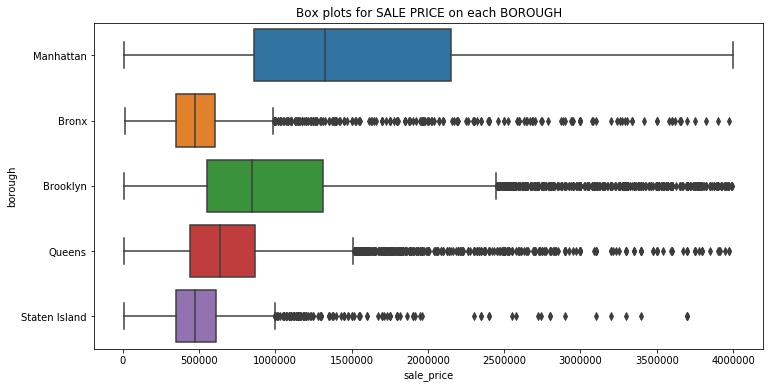

In [31]:
plt.figure(figsize=(12,6))
sns.boxplot(y = 'borough', x = 'sale_price', data = df_housing_clean )
plt.title('Box plots for SALE PRICE on each BOROUGH')
plt.show()

In [32]:
df_bar =df_housing_clean[['borough', 'sale_price']].groupby(by='borough').mean().sort_values(by='sale_price', ascending=True).reset_index()
df_bar

borough    sale_price
0  Staten Island  5.067751e+05
1          Bronx  5.579480e+05
2         Queens  7.098848e+05
3       Brooklyn  1.038700e+06
4      Manhattan  1.571737e+06

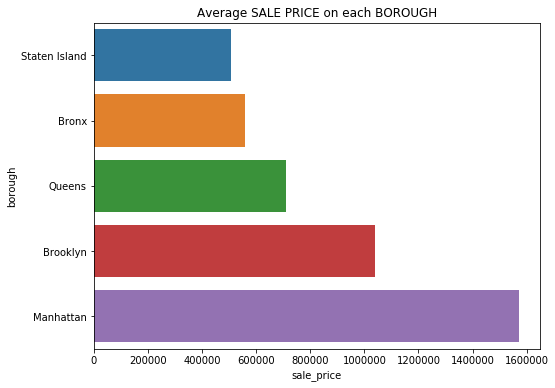

In [84]:
plt.figure(figsize=(8,6))
sns.barplot(y = 'borough', x = 'sale_price', data = df_bar )
plt.title('Average SALE PRICE on each BOROUGH')
plt.show()

below Population, Density & GDP data is extracted manually from wikipedia. 

In [34]:
df_ny_population = pd.read_csv('nyk_population.csv')

In [35]:
df_ny_population = df_ny_population.sort_values(by='population', ascending=True)

In [36]:
df_ny_population

borough    county  population  gdp_billions  gdp_capita    sqms  \
4  Staten Island  Richmond      476143        14.514       30500   58.37   
0          Bronx     Bronx     1418207        42.695       30100   42.10   
2      Manhattan  New York     1628706       600.244      368500   22.83   
3         Queens    Queens     2253858        93.310       41400  108.53   
1       Brooklyn     Kings     2559903        91.559       35800   70.82   

     sqkm  pers_sqms  pers_sqkm  
4  151.18       8157       3150  
0  109.04      33867      13006  
2   59.13      71341      27544  
3  281.09      20767       8018  
1  183.42      36147      13957

In [39]:
df_ny_stats = pd.merge(df_ny_population, df_bar)

In [40]:
df_ny_stats

borough    county  population  gdp_billions  gdp_capita    sqms  \
0  Staten Island  Richmond      476143        14.514       30500   58.37   
1          Bronx     Bronx     1418207        42.695       30100   42.10   
2      Manhattan  New York     1628706       600.244      368500   22.83   
3         Queens    Queens     2253858        93.310       41400  108.53   
4       Brooklyn     Kings     2559903        91.559       35800   70.82   

     sqkm  pers_sqms  pers_sqkm    sale_price  
0  151.18       8157       3150  5.067751e+05  
1  109.04      33867      13006  5.579480e+05  
2   59.13      71341      27544  1.571737e+06  
3  281.09      20767       8018  7.098848e+05  
4  183.42      36147      13957  1.038700e+06

#### Data Exploration

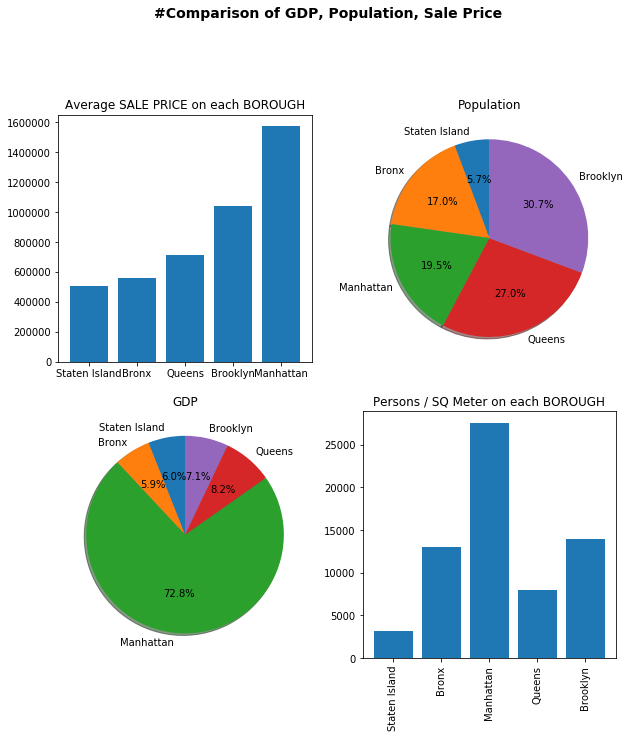

In [53]:
fig, ax = plt.subplots(figsize=(10, 10), nrows=2, ncols=2)


#first graph - bar plot highlighting avg sale price borough level
g1 = ax[0, 0].bar(data=df_bar, x='borough', height='sale_price');
plt.xticks(rotation=90)

#second graph pie chart for population
data = df_ny_stats['population']
label = df_ny_stats['Borough']
g2= ax[0, 1].pie(data, autopct='%1.1f%%', shadow=True, startangle=90, labels=label);
plt.xticks(rotation=90)

#third graph pie chart for gdp
data = df_ny_stats['gdp_capita']
label = df_ny_stats['Borough']
g3= ax[1,0].pie(data, autopct='%1.1f%%', shadow=True, startangle=90, labels=label);

#fourth graph - bar plot highlighting persons per sqm borough level
g4 = ax[1,1].bar(data=df_ny_stats, x='Borough', height='pers_sqkm');
plt.xticks(rotation=90)
ax[0, 0].title.set_text('Average SALE PRICE on each BOROUGH')
ax[0, 1].title.set_text('Population')
ax[1, 0].title.set_text('GDP')
ax[1, 1].title.set_text('Persons / SQ Meter on each BOROUGH')


plt.suptitle('#Comparison of GDP, Population, Sale Price', y=1.03, fontsize=14, fontweight='semibold');

**GDP**
The Major contributor of GDP is Manhattan, followed by Queens, Brooklyn, Stalen Island & Bronx.
**Avg sale price**
Prices were Manhattan, Brooklyn, Queens, Staten Island, Bronx.
**Person/SQM**
Person per SQM is high in the order Manhattan, Brooklyn, Bronx, Queens.
**Population**
Brooklyn, Queens, Manhattan, Bronx & Staten Island

I wish to perform neighborhoods exploration for **Queens** considering the facts mentioned in our problem description - lower real estate cost, population and better GDP. This will help in lowering the investment as well as consider better returns. In the next section lets explore the neighborhood data followed by segmentation to find top venues.

<a id='method'></a>
#### Methodology

 **Google Map API**, ‘Search Nearby’ option to get the center coordinates of the each Borough. **Population data** is captured from wiki page. We will be using **Foursquare API** for Neighborhoods data exploration. The information we want to focus on are shopping venues, coffee shops, and entertainment venues. We will choose top 2 boroughs based on population: **Manhattan & Brooklyn**. We need to apply Neighborhood Segmentation and Clustering to analyzing the neighborhood data and prioritize the best shopping location in both boroughs based on foot traffic and type of venues available. This helps the investor to choose the best place for business investment.

I am using Folium library to load the newyork map

In [42]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [43]:
empty_map = folium.Map(location=[latitude, longitude], zoom_start=10)

In [44]:
map_newyork = empty_map

In [45]:
df_ny_stats = df_ny_stats.rename(columns={'borough' : 'Borough'})

In [54]:
# create map of New York using latitude and longitude values
markers_colors = []

with open('nyborough.geojson') as json_data:
    nyborough_data = json.load(json_data)
    #label = folium.Popup( 'cluster '+str(cluster) + ' - ' + str(poi) + ' : ' + str(int(avg_hp)) + '. NH :' , parse_html=True)
map_newyork.choropleth(
    geo_data=nyborough_data,
    data=df_ny_stats,
    columns=['Borough', 'sale_price'],
    key_on='feature.properties.BoroName',
    fill_color='YlOrRd', 
    #label=df_ny_stats['Borough'], # hover text
    #label=folium.Popup('Mom & Pop Arrow Shop >>', parse_html=True),
    fill_opacity=0.5, 
    line_opacity=0.2,
    legend_name='House Price in NewYork'#,
    #marker_line_color='white', # line markers between states
    #colorbar_title="House Price in NewYork" 
)

map_newyork

<a id='nbexplore'></a>
### Neighborhoods exploration

we are going to start utilizing the Foursquare API to explore the neighborhoods for segment them.

Define Foursquare Credentials and Version

Get the neighborhood's name.

I have Limit to 100 venues within a radius of 500 meters. 

In [55]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 750 # define radius

Method is created to reuse the code for both the borough

In [56]:
def getNearbyVenues(names, latitudes, longitudes, radius=750):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [57]:
neighborhoods = neighborhoods[neighborhoods['Borough'] == 'Queens']

In [75]:
venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude'],
                                   radius=radius
                                  )

Astoria
Woodside
Jackson Heights
Elmhurst
Howard Beach
Corona
Forest Hills
Kew Gardens
Richmond Hill
Flushing
Long Island City
Sunnyside
East Elmhurst
Maspeth
Ridgewood
Glendale
Rego Park
Woodhaven
Ozone Park
South Ozone Park
College Point
Whitestone
Bayside
Auburndale
Little Neck
Douglaston
Glen Oaks
Bellerose
Kew Gardens Hills
Fresh Meadows
Briarwood
Jamaica Center
Oakland Gardens
Queens Village
Hollis
South Jamaica
St. Albans
Rochdale
Springfield Gardens
Cambria Heights
Rosedale
Far Rockaway
Broad Channel
Breezy Point
Steinway
Beechhurst
Bay Terrace
Edgemere
Arverne
Rockaway Beach
Neponsit
Murray Hill
Floral Park
Holliswood
Jamaica Estates
Queensboro Hill
Hillcrest
Ravenswood
Lindenwood
Laurelton
Lefrak City
Belle Harbor
Rockaway Park
Somerville
Brookville
Bellaire
North Corona
Forest Hills Gardens
Jamaica Hills
Utopia
Pomonok
Astoria Heights
Hunters Point
Sunnyside Gardens
Blissville
Roxbury
Middle Village
Malba
Hammels
Bayswater
Queensbridge


In [59]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 315 uniques categories.


In [60]:
# one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighborhood'] = venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot.shape

(3785, 315)

In [61]:
grouped = onehot.groupby('Neighborhood').mean().reset_index()
print(grouped.shape)

(81, 315)


In [62]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [63]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = grouped['Neighborhood']

for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0          Arverne             Surf Spot                 Beach   
1          Astoria                   Bar      Greek Restaurant   
2  Astoria Heights   Rental Car Location                Bakery   
3       Auburndale     Korean Restaurant        Cosmetics Shop   
4      Bay Terrace        Clothing Store        Cosmetics Shop   

       3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0              Deli / Bodega        Sandwich Place              Bus Stop   
1  Middle Eastern Restaurant           Pizza Place    Seafood Restaurant   
2                Bus Station           Pizza Place                  Café   
3                Pizza Place      Sushi Restaurant      Greek Restaurant   
4          Mobile Phone Shop         Women's Store            Kids Store   

  6th Most Common Venue   7th Most Common Venue 8th Most Common Venue  \
0            Donut Shop  Furniture / Home Store                  Café   
1           Coffee Shop              Hookah Bar         Grocery Store   
2    Italian Restaurant                   Hotel            Laundromat   
3        Sandwich Place                    Bank             Pet Store   
4        Lingerie Store     American Restaurant            Donut Shop   

  9th Most Common Venue 10th Most Common Venue  
0       Bed & Breakfast            Gas Station  
1        Sandwich Place      Indian Restaurant  
2        Baseball Field     Chinese Restaurant  
3              Pharmacy   Gym / Fitness Center  
4            Shoe Store            Men's Store

In [64]:
neighborhoods_venues_sorted.shape

(81, 11)

In [65]:
print(grouped.shape)

(81, 315)


<a id='segment'></a>
### Segmentation (Clustering)

In [66]:
grouped_clustering = grouped.drop('Neighborhood', 1)

In [67]:
grouped.head()

Neighborhood  Zoo Exhibit  Accessories Store  Afghan Restaurant  \
0          Arverne          0.0           0.000000                0.0   
1          Astoria          0.0           0.000000                0.0   
2  Astoria Heights          0.0           0.000000                0.0   
3       Auburndale          0.0           0.000000                0.0   
4      Bay Terrace          0.0           0.023256                0.0   

   Airport Lounge  Airport Service  American Restaurant  Arepa Restaurant  \
0             0.0              0.0             0.000000              0.00   
1             0.0              0.0             0.010000              0.01   
2             0.0              0.0             0.000000              0.00   
3             0.0              0.0             0.028169              0.00   
4             0.0              0.0             0.046512              0.00   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                     0.0          0.0         0.0                  0.0   
1                     0.0          0.0         0.0                  0.0   
2                     0.0          0.0         0.0                  0.0   
3                     0.0          0.0         0.0                  0.0   
4                     0.0          0.0         0.0                  0.0   

   Arts & Entertainment  Asian Restaurant  Athletics & Sports  \
0                   0.0               0.0            0.000000   
1                   0.0               0.0            0.000000   
2                   0.0               0.0            0.000000   
3                   0.0               0.0            0.014085   
4                   0.0               0.0            0.000000   

   Australian Restaurant  Auto Dealership  Auto Workshop  Automotive Shop  \
0                    0.0              0.0            0.0              0.0   
1                    0.0              0.0            0.0              0.0   
2                    0.0              0.0            0.0              0.0   
3                    0.0              0.0            0.0              0.0   
4                    0.0              0.0            0.0              0.0   

   BBQ Joint  Bagel Shop    Bakery      Bank       Bar  Baseball Field  \
0       0.00        0.00  0.000000  0.035714  0.000000        0.000000   
1       0.01        0.02  0.030000  0.000000  0.070000        0.000000   
2       0.00        0.00  0.057143  0.000000  0.000000        0.028571   
3       0.00        0.00  0.000000  0.028169  0.014085        0.000000   
4       0.00        0.00  0.023256  0.023256  0.000000        0.000000   

   Baseball Stadium  Basketball Court  Bath House     Beach  Beach Bar  \
0               0.0               0.0         0.0  0.071429        0.0   
1               0.0               0.0         0.0  0.000000        0.0   
2               0.0               0.0         0.0  0.000000        0.0   
3               0.0               0.0         0.0  0.000000        0.0   
4               0.0               0.0         0.0  0.000000        0.0   

   Bed & Breakfast  Beer Garden  Bike Trail  Bistro  Board Shop  \
0         0.035714         0.00         0.0     0.0    0.035714   
1         0.000000         0.01         0.0     0.0    0.000000   
2         0.000000         0.00         0.0     0.0    0.000000   
3         0.000000         0.00         0.0     0.0    0.000000   
4         0.000000         0.00         0.0     0.0    0.000000   

   Boat or Ferry  Bookstore  Border Crossing  Botanical Garden  Boutique  \
0            0.0        0.0              0.0               0.0       0.0   
1            0.0        0.0              0.0               0.0       0.0   
2            0.0        0.0              0.0               0.0       0.0   
3            0.0        0.0              0.0               0.0       0.0   
4            0.0        0.0              0.0               0.0       0.0   

   Bowling Alley  Boxing Gym  Brazilian Restauran

In [68]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 0, 0, 0, 0, 2, 0, 3, 1])

In [69]:
#neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop('Cluster Labels', axis=1)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
neighborhoods_merged =pd.merge(neighborhoods, neighborhoods_venues_sorted, on='Neighborhood', how='inner')
#
neighborhoods_merged = neighborhoods_merged.merge(df_ny_stats, on='Borough')

neighborhoods_merged.head() # check the last columns!

Borough     Neighborhood   Latitude  Longitude  Cluster Labels  \
0  Queens          Astoria  40.768509 -73.915654               0   
1  Queens         Woodside  40.746349 -73.901842               0   
2  Queens  Jackson Heights  40.751981 -73.882821               0   
3  Queens         Elmhurst  40.744049 -73.881656               0   
4  Queens     Howard Beach  40.654225 -73.838138               0   

       1st Most Common Venue      2nd Most Common Venue  \
0                        Bar           Greek Restaurant   
1            Thai Restaurant                Pizza Place   
2  Latin American Restaurant  South American Restaurant   
3            Thai Restaurant         Mexican Restaurant   
4         Italian Restaurant                 Bagel Shop   

       3rd Most Common Venue 4th Most Common Venue      5th Most Common Venue  \
0  Middle Eastern Restaurant           Pizza Place         Seafood Restaurant   
1                        Bar         Grocery Store                     Bakery   
2                     Bakery    Mexican Restaurant        Peruvian Restaurant   
3         Chinese Restaurant                Bakery  South American Restaurant   
4                   Pharmacy  Fast Food Restaurant             Sandwich Place   

       6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0                Coffee Shop            Hookah Bar         Grocery Store   
1  Latin American Restaurant   American Restaurant                   Pub   
2                Pizza Place       Thai Restaurant         Grocery Store   
3  Latin American Restaurant         Grocery Store           Supermarket   
4             Ice Cream Shop                  Park      Sushi Restaurant   

  9th Most Common Venue 10th Most Common Venue  county  population  \
0        Sandwich Place      Indian Restaurant  Queens     2253858   
1   Filipino Restaurant             Donut Shop  Queens     2253858   
2           Coffee Shop             Donut Shop  Queens     2253858   
3       Bubble Tea Shop            Snack Place  Queens     2253858   
4       Other Nightlife            Bus Station  Queens     2253858   

   gdp_billions  gdp_capita    sqms    sqkm  pers_sqms  pers_sqkm  \
0         93.31       41400  108.53  281.09      20767       8018   
1         93.31       41400  108.53  281.09      20767       8018   
2         93.31       41400  108.53  281.09      20767       8018   
3         93.31       41400  108.53  281.09      20767       8018   
4         93.31       41400  108.53  281.09      20767       8018   

      sale_price  
0  709884.787686  
1  709884.787686  
2  709884.787686  
3  709884.787686  
4  709884.787686

In [70]:
#neighborhoods_c1 = 
neighborhoods_c1 = neighborhoods_merged[neighborhoods_merged['Cluster Labels'] == 0][['Neighborhood', '1st Most Common Venue']].groupby('1st Most Common Venue').count().sort_values (by=['Neighborhood'], ascending=False).head(10).reset_index()
neighborhoods_c1["Cluster"] = 1

neighborhoods_c2 = neighborhoods_merged[neighborhoods_merged['Cluster Labels'] == 1][['Neighborhood', '1st Most Common Venue']].groupby('1st Most Common Venue').count().sort_values (by=['Neighborhood'], ascending=False).head(10).reset_index()
neighborhoods_c2["Cluster"] = 2

neighborhoods_c3 = neighborhoods_merged[neighborhoods_merged['Cluster Labels'] == 2][['Neighborhood', '1st Most Common Venue']].groupby('1st Most Common Venue').count().sort_values (by=['Neighborhood'], ascending=False).head(10).reset_index()
neighborhoods_c3["Cluster"] = 3

neighborhoods_c4 = neighborhoods_merged[neighborhoods_merged['Cluster Labels'] == 3][['Neighborhood', '1st Most Common Venue']].groupby('1st Most Common Venue').count().sort_values (by=['Neighborhood'], ascending=False).head(10).reset_index()
neighborhoods_c4["Cluster"] = 4

neighborhoods_c5 = neighborhoods_merged[neighborhoods_merged['Cluster Labels'] == 4][['Neighborhood', '1st Most Common Venue']].groupby('1st Most Common Venue').count().sort_values (by=['Neighborhood'], ascending=False).head(10).reset_index()
neighborhoods_c5["Cluster"] = 5

neighborhoods_c6 = neighborhoods_merged[neighborhoods_merged['Cluster Labels'] == 5][['Neighborhood', '1st Most Common Venue']].groupby('1st Most Common Venue').count().sort_values (by=['Neighborhood'], ascending=False).head(10).reset_index()
neighborhoods_c6["Cluster"] = 6

df_tmp = pd.concat([neighborhoods_c1, neighborhoods_c2])
df_tmp = pd.concat([df_tmp, neighborhoods_c3])
df_tmp = pd.concat([df_tmp, neighborhoods_c4])
df_tmp = pd.concat([df_tmp, neighborhoods_c5])
df_tmp = pd.concat([df_tmp, neighborhoods_c6])

df_tmp.sort_values (by=['Cluster'], ascending=True).reset_index()

df_final = df_tmp

<a id='results'></a>
### Results

A map plotted to visualize the neighborhoods by its clusters - chloropleth map is created to highlight the boroughs by its house average sales.

In [81]:
from folium import ColorMap, LinearColormap, StepColormap

map_clusters = empty_map

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#neighborhoods_merged['text'] = neighborhoods_merged['Borough'] + neighborhoods_merged['Neighborhood'] + '<br>' #+ \
    #'Most Common Venue(s) ' + neighborhoods_merged['1st Most Common Venue'] + ', ' + neighborhoods_merged['2nd Most Common Venue']

#' Dairy ' + neighborhoods_merged['dairy'] + '<br>' + \
    #'Population ' + neighborhoods_merged['total fruits'] + ' Per SQM ' + neighborhoods_merged['total veggies'] + '<br>' + \


# add markers to the map
markers_colors = []

with open('nyborough.geojson') as json_data:
    nyborough_data = json.load(json_data)
    
map_clusters.choropleth(
    geo_data=nyborough_data,
    data=df_ny_stats,
    columns=['Borough', 'sale_price'],
    key_on='feature.properties.BoroName',
    fill_color='YlOrRd', 
    #text=df_ny_stats['Borough'], # hover text
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='House Price in NewYork'#,
    #marker_line_color='white', # line markers between states
    #colorbar_title="House Price in NewYork"
)

for cluster, cluster_name, lat, lon, poi, borough, avg_hp in zip(
                                  neighborhoods_merged['Cluster Labels'],
                                  neighborhoods_merged['Cluster'], 
                                  neighborhoods_merged['Latitude'], 
                                  neighborhoods_merged['Longitude'], 
                                  neighborhoods_merged['Neighborhood'], 
                                  neighborhoods_merged['Borough'],
                                  neighborhoods_merged['sale_price']):
    label = folium.Popup( 'borough : '+borough+', cluster : '+cluster_name + ', nh: ' + poi + ' : ' + str(int(avg_hp)) + '' , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters) 

map_clusters

Cluster visualization, bar graphs developed to visualize what venue categories are available for each clusters.

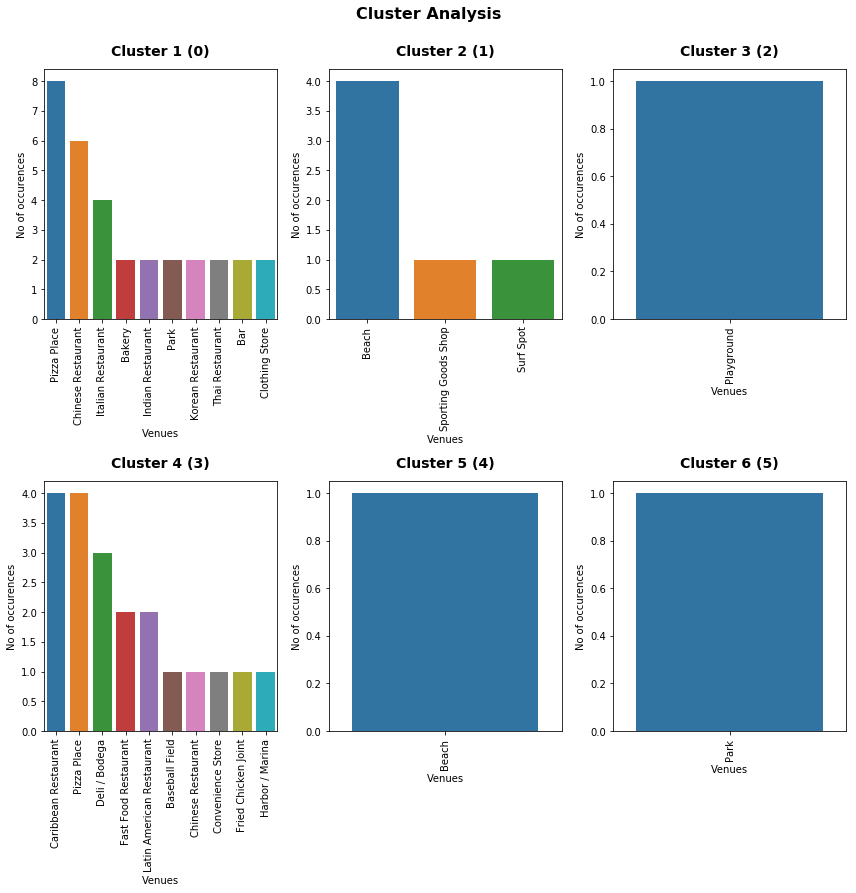

In [73]:
plt.figure(figsize=(12,12))
plt.suptitle('Cluster Analysis', y=1.03, fontsize=16, fontweight='semibold');

plt.subplot(2, 3, 1);
g = sns.barplot(data=neighborhoods_c1, x="1st Most Common Venue", y = 'Neighborhood');
g.set_title('Cluster 1 (0)', y=1.03, fontsize=14, fontweight='semibold');
g.set_xlabel('Venues');
g.set_ylabel('No of occurences');

plt.xticks(rotation=90)

plt.subplot(2, 3, 2);
g = sns.barplot(data=neighborhoods_c2, x="1st Most Common Venue", y = 'Neighborhood');
g.set_title('Cluster 2 (1)', y=1.03, fontsize=14, fontweight='semibold');
g.set_xlabel('Venues');
g.set_ylabel('No of occurences');

plt.xticks(rotation=90)

# code for the pie chart
plt.subplot(2, 3, 3);
g = sns.barplot(data=neighborhoods_c3, x="1st Most Common Venue", y = 'Neighborhood');
g.set_title('Cluster 3 (2)', y=1.03, fontsize=14, fontweight='semibold');
g.set_xlabel('Venues');
g.set_ylabel('No of occurences');

plt.xticks(rotation=90)

plt.suptitle('Cluster Analysis', y=1.03, fontsize=16, fontweight='semibold');
base_color = sns.color_palette()[0]
# code for the bar chart
plt.subplot(2, 3, 4);
g = sns.barplot(data=neighborhoods_c4, x="1st Most Common Venue", y = 'Neighborhood');
g.set_title('Cluster 4 (3)', y=1.03, fontsize=14, fontweight='semibold');
g.set_xlabel('Venues');
g.set_ylabel('No of occurences');

plt.xticks(rotation=90)

plt.subplot(2, 3, 5);
g = sns.barplot(data=neighborhoods_c5, x="1st Most Common Venue", y = 'Neighborhood');
g.set_title('Cluster 5 (4)', y=1.03, fontsize=14, fontweight='semibold');
g.set_xlabel('Venues');
g.set_ylabel('No of occurences');

plt.xticks(rotation=90)

# code for the pie chart
plt.subplot(2, 3, 6);
g = sns.barplot(data=neighborhoods_c6, x="1st Most Common Venue", y = 'Neighborhood');
g.set_title('Cluster 6 (5)', y=1.03, fontsize=14, fontweight='semibold');
g.set_xlabel('Venues');
g.set_ylabel('No of occurences');

plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

**Clusters are categorized as follows**
<ul>
    <li>Cluster 1 - Food/Clothing. </li>
    <li>Cluster 2 - Beaches/sports </li>
    <li>Cluster 3 - Sports </li>
    <li>Cluster 4 - Food/Harbor </li>
    <li>Cluster 5 - Beach </li>
    <li>Cluster 6 - Park </li>
</ul>

In [74]:
neighborhoods_merged['Cluster']= neighborhoods_merged['Cluster Labels'].map({0:'Food/Clothing.', 
                                    1:'Beaches/sports', 
                                    2: 'Sports', 
                                    3:'Food/Harbor',
                                    4:'Beach',
                                    5:'Park'
                                       }) 

Data exploration results helps to understand the population denisty , GDP and housing pricing to compare and decide which borough to choose for clustering analysis.
From the results on clustering, based on the type of business one is investing can choose the cluster and the map helps in selecting the area in which the business can be built.

<a id='discussion'></a>
### Discussion

Newyork is a popular city in US. The city has 5 boroughs and for this project I have considered **Queens** based on the real estate pricing (low) with good population density and good GDP rate. 
The interactive map could help the investors in assessment of finding a suitable neighborhood based on the business the investor is interested in.  

<a id='conclusion'></a>
### Conclusion

The popular city new york in United State has Manhattan as the most expensive borough with median population comparing with its peer boroughs. Manhattan also provides 72% of the GDP. Business investors with high budget can opt for Manhattan which has better GDP. 
Queens with its high population and low average housing cost could be a better investment option. Cluster 1/4 with high number of restaurant venues should be a good place for investing on related business that supports restaurants and bars. eg. Food supplies etc.  

Also further analysis can be done for different boroughs, cities depending on the investors needs. I could imagine this can be extended further by having webbased UI that could ask user to choose city ie. New York and then the map with choropleth can be diplayed and based on selection of the borough the report could be dynamically generated. Not just for retailers, this can be usable by home investors, government etc.

<a id='references'></a>
### References

<ul>
    <li> https://en.wikipedia.org/wiki/New_York_City</li>
    <li>https://www.kaggle.com/new-york-city/nyc-property-sales</li>
    <li>https://geo.nyu.edu/catalog/nyu_2451_34572</li>
    <li>https://developer.foursquare.com/</li>
    <li>https://www.google.com/maps/</li>
    <li>https://cdn.wallpapersafari.com/34/75/CwGD1o.jpg</li>
</ul>